In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from scipy.constants import eV, h, c, femto, peta, lambda2nu

from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import RegularGridInterpolator

from numpy.fft import fft, ifft, fftshift, fftfreq, ifftshift

import glob

def phz2ev(x):
    scale = h/eV/femto
    return x*scale

def coh2spec(t, wl, coh, zpad=4):
    """
    Convert t-wl coherence to f-f 2D spectrum.

    Fourier transforms along t and converts wl to f. Intensities are corrected
    for un-even wl spacing and for wl-f transformation. Units are assumed to be
    fs, nm.

    Parameters
    ----------
    t : (N,) np.ndarray
        Time values. Constant spacing is assumed.
    wl : (M,) np.ndarray
        Wavelength array
    coh : (M,N) np.ndarray
        Coherence (ie: cycled)
    zpad : int
        Zero-padding factor.

    Returns
    -------
    f_ex : (N',) np.ndarray
        Excitation frequencies. N' is approx zpad*N/2
    f_em : (M,) np.ndarray
        Emission frequencies.
    spec : (M, N') np.ndarray
        2D spectrum. Appropriately corrected for jacobian (the result is a
        distribution function)
    """
    assert t.ndim == 1
    assert wl.ndim == 1
    assert coh.ndim == 2
    c = 3E8 * 1E9 / 1E15  # nm/fs
    nfft = t.size*zpad
    f_ex = fftshift(fftfreq(nfft, t[1]-t[0]))
    coh = coh.copy()
    coh[:,0] *= 0.5
    spec = fftshift(fft(coh, nfft, axis=1), axes=1)
    #mask = f_ex<=0
    #spec = spec[:,mask]
    #f_ex = f_ex[mask]
    f_em = c/wl
	#finite Jacobian transform
    d_f_em = np.zeros(f_em.shape)
    d_f_em[:-1] = f_em[1:] - f_em[:-1]
    d_f_em[-1] = d_f_em[-2]  # repeat last value. Shouln't be meaningful data anyways
    spec /= d_f_em[:,np.newaxis]
    return f_ex, f_em, spec

def baseline(y):
    mn = np.min(y, axis=1)
    span = np.max(y, axis=1) - mn
    baseline_mask = y < (0.1*span + mn)[:,np.newaxis]
    assert np.any(baseline_mask)
    assert ~np.all(baseline_mask)
    baseline = np.array([np.median(y[i,:].compress(baseline_mask[i,:]))
                        for i in np.arange(y.shape[0])])
    return baseline

def coh3(d):
    #return data[::2,:,:] - data[1::2,:,:]
    return - data[::4,:,:] + data[1::4,:,:] + data[2::4,:,:] - data[3::4,:,:]

def mk_spec(t1, wl, coh):
    s = np.array([coh2spec(t1, wl, coh[:,i,:].T)[2]
                  for i in range(coh.shape[1])])
    return np.rollaxis(s, -1, 0)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

In [2]:
files = glob.glob(r"trial_06_data_rep_*.npz")

stack_input = np.zeros((35,60,161,30))
for i,file in enumerate(files):
    dset = np.load(file)

    t1 = dset["t1"]
    wl = dset["wl"]
    t2 = dset["t2"]

    # remove baseline from data waves
    data = dset["data"]
    data_bl = np.array([baseline(data[:,i,:]) for i in np.arange(t2.size)]).T
    data = data - data_bl[:,:,np.newaxis]

    win = np.exp(-0.5*(t1/35)**2)[:,np.newaxis,np.newaxis]
    c3 = coh3(data)
    s3 = -mk_spec(t1, wl, c3)

    f1, f3, _ = coh2spec(t1, wl, c3[:,0,:].T)
    f1 = f1 + 0.399654
    e_x = phz2ev(f1)

    e_em = phz2ev(f3)


    lower = 1.95
    upper = 2.25

    e_x_mask = (e_x >= lower) & (e_x <= upper)
    em_mask = (e_em >= lower) & (e_em <= upper)

    s3 = s3.compress(em_mask, axis=2).compress(e_x_mask, axis=0)
    e_em = e_em.compress(em_mask)
    e_x = e_x.compress(e_x_mask)

    stack_input[:,:,:,i] = s3
e_ex = e_x

C:\Users\patri\AppData\Local\Temp\ipykernel_10888\3740221677.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  stack_input[:,:,:,i] = s3


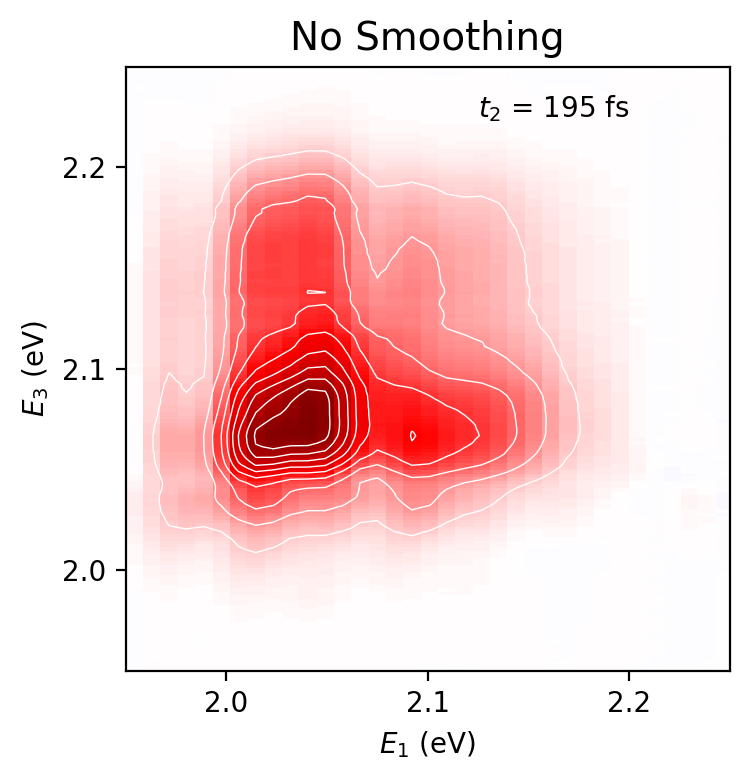

In [4]:
stack_average = np.average(stack_input,axis=-1)
out_f = r'cdse_average.gif'
writer = FFMpegWriter(fps=10)
fig = plt.figure(figsize=(4,4),dpi=200,facecolor='white')

temp_t2 = np.hstack((t2,t2))
with writer.saving(fig, out_f, 300):   
    for t2_time in np.sort(temp_t2):
        fig.clear()
        
        time_index = np.argmin(np.abs(t2-t2_time))
        spec = stack_average
        scale = np.max(np.abs(spec[:, time_index, :]))
        plot_spec = np.real(spec[:, time_index, :].T)/scale

        plt.pcolormesh(e_ex,e_em,plot_spec,cmap="seismic_r",vmin=-1,vmax=1)
        plt.contour(e_ex, e_em,plot_spec,colors='w', levels=np.linspace(-1, 1, 21),linewidths=0.5)
        plt.xlim(1.95,2.25)
        plt.ylim(1.95,2.25)
        plt.xlabel(r"$E_1$ (eV)")
        plt.ylabel(r"$E_3$ (eV)")
        plt.xticks([2,2.1,2.2])
        plt.yticks([2,2.1,2.2])
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.title("No Smoothing",fontsize=14)
        plt.text(2.125,2.225,"$t_2$ = %0.0f fs"%t2_time,c="k")

        writer.grab_frame()

In [ ]:
stack_average = np.average(stack_input,axis=-1)

stack_average = gaussian_filter1d(gaussian_filter1d(stack_average,5,axis=-1),1,axis=0)

out_f = r'cdse_average_smooth_1.gif'

writer = FFMpegWriter(fps=10)

e_ex = e_x
fig = plt.figure(figsize=(4,4),dpi=200,facecolor='white')

i = 0
j = 0       

temp_t2 = np.hstack((t2,t2))
with writer.saving(fig, out_f, 300):   
    for t2_time in np.sort(temp_t2):#[0,1,2,3,4,5]:
        fig.clear()
        time_index = np.argmin(np.abs(t2-t2_time))

        spec = stack_average#[:,:,:]
        scale = np.max(np.abs(spec[:, time_index, :]))
        plot_spec = np.real(spec[:, time_index, :].T)/scale

        plt.pcolormesh(e_ex,e_em,plot_spec,cmap="seismic_r",vmin=-1,vmax=1)
    #     plt.colorbar()
        plt.contour(e_ex, e_em,plot_spec,colors='w', levels=np.linspace(-1, 1, 21),linewidths=0.5)
        #plt.contourf(e_ex, e_em,plot_spec,cmap='jet_r', levels=np.linspace(-1, 0, 21),linewidths=2)
        plt.xlim(1.95,2.25)
        plt.ylim(1.95,2.25)
        plt.xlabel(r"$E_1$ (eV)")
        plt.ylabel(r"$E_3$ (eV)")
        plt.xticks([2,2.1,2.2])
        plt.yticks([2,2.1,2.2])
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.title("Smoothing, $\sigma$ = 1",fontsize=14)

        plt.text(2.125,2.225,"$t_2$ = %0.0f fs"%t2_time,c="k")
        # if t2_time == 15.0:
        #     plt.text(1.975,2.225,"Outlier",c="r")
            
        # plt.tight_layout()
        writer.grab_frame()

In [ ]:
stack_average = np.average(stack_input,axis=-1)
stack_average = gaussian_filter1d(gaussian_filter1d(stack_average,20,axis=-1),4,axis=0)
out_f = r'cdse_average_smooth_4.gif'

writer = FFMpegWriter(fps=10)

e_ex = e_x
fig = plt.figure(figsize=(4,4),dpi=200,facecolor='white')

i = 0
j = 0       

temp_t2 = np.hstack((t2,t2))
with writer.saving(fig, out_f, 300):   
    for t2_time in np.sort(temp_t2):#[0,1,2,3,4,5]:
        fig.clear()
        time_index = np.argmin(np.abs(t2-t2_time))

        spec = stack_average#[:,:,:]
        scale = np.max(np.abs(spec[:, time_index, :]))
        plot_spec = np.real(spec[:, time_index, :].T)/scale

        plt.pcolormesh(e_ex,e_em,plot_spec,cmap="seismic_r",vmin=-1,vmax=1)
    #     plt.colorbar()
        plt.contour(e_ex, e_em,plot_spec,colors='w', levels=np.linspace(-1, 1, 21),linewidths=0.5)
        #plt.contourf(e_ex, e_em,plot_spec,cmap='jet_r', levels=np.linspace(-1, 0, 21),linewidths=2)
        plt.xlim(1.95,2.25)
        plt.ylim(1.95,2.25)
        plt.xlabel(r"$E_1$ (eV)")
        plt.ylabel(r"$E_3$ (eV)")
        plt.xticks([2,2.1,2.2])
        plt.yticks([2,2.1,2.2])
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.title("Smoothing, $\sigma$ = 4",fontsize=14)

        plt.text(2.125,2.225,"$t_2$ = %0.0f fs"%t2_time,c="k")
        # if t2_time == 15.0:
        #     plt.text(1.975,2.225,"Outlier",c="r")
            
        # plt.tight_layout()
        writer.grab_frame()

In [ ]:
#Create reader object for the gif
gif1 = imageio.get_reader('cdse_average.gif')
gif2 = imageio.get_reader('cdse_average_smooth_1.gif')
gif3 = imageio.get_reader('cdse_average_smooth_4.gif')

#If they don't have the same number of frame take the shorter
number_of_frames = min(gif1.get_length(), gif2.get_length(), gif3.get_length()) 

#Create writer object
new_gif = imageio.get_writer('output.gif')

for frame_number in range(number_of_frames):
    img1 = gif1.get_next_data()
    img2 = gif2.get_next_data()
    img3 = gif3.get_next_data()
    #here is the magic
    new_image = np.hstack((img1, img2, img3))
    new_gif.append_data(new_image)

gif1.close()
gif2.close()    
gif3.close()  
new_gif.close()

Interpolate Grid

In [ ]:
stack_average = np.average(stack_input,axis=-1)
stack_average = gaussian_filter1d(gaussian_filter1d(stack_average,5,axis=-1),1,axis=0)
out_f = r'cdse_average_smooth_1.gif'

writer = FFMpegWriter(fps=10)

e_ex = e_x
fig = plt.figure(figsize=(4,4),dpi=200,facecolor='white')

i = 0
j = 0       

temp_t2 = np.hstack((t2,t2))
with writer.saving(fig, out_f, 300):   
    for t2_time in np.sort(temp_t2):#[0,1,2,3,4,5]:
        fig.clear()
        time_index = np.argmin(np.abs(t2-t2_time))

        spec = stack_average#[:,:,:]
        scale = np.max(np.abs(spec[:, time_index, :]))
        plot_spec = np.real(spec[:, time_index, :].T)/scale

        plt.pcolormesh(e_ex,e_em,plot_spec,cmap="seismic_r",vmin=-1,vmax=1)
    #     plt.colorbar()
        plt.contour(e_ex, e_em,plot_spec,colors='w', levels=np.linspace(-1, 1, 21),linewidths=0.5)
        #plt.contourf(e_ex, e_em,plot_spec,cmap='jet_r', levels=np.linspace(-1, 0, 21),linewidths=2)
        plt.xlim(1.95,2.25)
        plt.ylim(1.95,2.25)
        plt.xlabel(r"$E_1$ (eV)")
        plt.ylabel(r"$E_3$ (eV)")
        plt.xticks([2,2.1,2.2])
        plt.yticks([2,2.1,2.2])
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.title("No interpolation",fontsize=14)

        plt.text(2.125,2.225,"$t_2$ = %0.0f fs"%t2_time,c="k")
        # if t2_time == 15.0:
        #     plt.text(1.975,2.225,"Outlier",c="r")
            
        # plt.tight_layout()
        writer.grab_frame()

In [ ]:
stack_average = np.average(stack_input,axis=-1)
stack_average = gaussian_filter1d(gaussian_filter1d(stack_average,5,axis=-1),1,axis=0)

t2_sorted = np.sort(t2)
temp = np.zeros(stack_average.shape)
for i,t in enumerate(t2_sorted):
    t2_index = np.argmin(np.abs(t2-t))
    temp[:,i,:] = stack_average[:,t2_index,:]
stack_average = temp

e_em_new = e_em[::-1]
stack_average = stack_average[:,:,::-1]

interp = RegularGridInterpolator((e_ex, t2_sorted, e_em_new), stack_average)
t2_new = np.linspace(t2_sorted[0],t2_sorted[-1],60)
e_ex_new = np.linspace(e_ex[0],e_ex[-1],200)
e_em_new = np.linspace(e_em_new[0],e_em_new[-1],200)
X, Y, Z = np.meshgrid(e_ex_new,t2_new,e_em_new, indexing='ij')
stack_average = interp((X,Y,Z))

out_f = r'cdse_average_smooth_interp.gif'

writer = FFMpegWriter(fps=5)

e_ex = e_x
fig = plt.figure(figsize=(4,4),dpi=200,facecolor='white')

t2_new = np.hstack((t2_sorted,t2_sorted))
with writer.saving(fig, out_f, 300):   
    for t2_time in np.sort(t2_new):#[0,1,2,3,4,5]:
        fig.clear()
        time_index = np.argmin(np.abs(t2_new-t2_time))

        spec = stack_average#[:,:,:]
        scale = np.max(np.abs(spec[:, time_index, :]))
        plot_spec = np.real(spec[:, time_index, :].T)/scale

        plt.pcolormesh(e_ex_new,e_em_new,plot_spec,cmap="seismic_r",vmin=-1,vmax=1)
    #     plt.colorbar()
        plt.contour(e_ex_new, e_em_new,plot_spec,colors='w', levels=np.linspace(-1, 1, 21),linewidths=0.5)
        #plt.contourf(e_ex, e_em,plot_spec,cmap='jet_r', levels=np.linspace(-1, 0, 21),linewidths=2)
        plt.xlim(1.95,2.25)
        plt.ylim(1.95,2.25)
        plt.xlabel(r"$E_1$ (eV)")
        plt.ylabel(r"$E_3$ (eV)")
        plt.xticks([2,2.1,2.2])
        plt.yticks([2,2.1,2.2])
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.title("Re-interpolated frames",fontsize=14)

        plt.text(2.125,2.225,"$t_2$ = %0.0f fs"%t2_time,c="k")
        # if t2_time == 15.0:
        #     plt.text(1.975,2.225,"Outlier",c="r")
            
        # plt.tight_layout()
        writer.grab_frame()

In [ ]:
#Create reader object for the gif
gif1 = imageio.get_reader('cdse_average_smooth_1.gif')
gif2 = imageio.get_reader('cdse_average_smooth_interp.gif')

print(gif1.get_length())
print(gif2.get_length())
#If they don't have the same number of frame take the shorter
number_of_frames = min(gif1.get_length(), gif2.get_length()) 

#Create writer object
new_gif = imageio.get_writer('cdse_average_smooth_interp_stitch.gif')

for frame_number in range(int(number_of_frames/2)):
    img1 = gif1.get_next_data()
    img2 = gif2.get_next_data()
    #here is the magic
    new_image = np.hstack((img1, img2))
    new_gif.append_data(new_image)

gif1.close()
gif2.close()    
new_gif.close()

In [ ]:
stack_average = np.average(stack_input,axis=-1)
stack_average = gaussian_filter1d(gaussian_filter1d(stack_average,5,axis=-1),1,axis=0)

t2_sorted = np.sort(t2)
temp = np.zeros(stack_average.shape)
for i,t in enumerate(t2_sorted):
    t2_index = np.argmin(np.abs(t2-t))
    temp[:,i,:] = stack_average[:,t2_index,:]
stack_average = temp

e_em_new = e_em[::-1]
stack_average = stack_average[:,:,::-1]

interp = RegularGridInterpolator((e_ex, t2_sorted, e_em_new), stack_average)
t2_new = np.linspace(t2_sorted[0],t2_sorted[-1],60)
e_ex_new = np.linspace(e_ex[0],e_ex[-1],200)
e_em_new = np.linspace(e_em_new[0],e_em_new[-1],200)
X, Y, Z = np.meshgrid(e_ex_new,t2_new,e_em_new, indexing='ij')
# stack_average = interp((e_ex,t2_sorted,e_em_new))
stack_average = interp((X,Y,Z))

out_f = r'cdse_average_smooth_interp.gif'

writer = FFMpegWriter(fps=20)

e_ex = e_x
fig = plt.figure(figsize=(4,4),dpi=200,facecolor='white')

i = 0
j = 0       

t2_new = np.hstack((t2_sorted,t2_sorted,t2_sorted,t2_sorted))
with writer.saving(fig, out_f, 300):   
    for t2_time in np.sort(t2_new):#[0,1,2,3,4,5]:
        fig.clear()
        time_index = np.argmin(np.abs(t2_new-t2_time))

        spec = stack_average#[:,:,:]
        scale = np.max(np.abs(spec[:, time_index, :]))
        plot_spec = np.real(spec[:, time_index, :].T)/scale

        plt.pcolormesh(e_ex_new,e_em_new,plot_spec,cmap="seismic_r",vmin=-1,vmax=1)
    #     plt.colorbar()
        plt.contour(e_ex_new, e_em_new,plot_spec,colors='w', levels=np.linspace(-1, 1, 21),linewidths=0.5)
        #plt.contourf(e_ex, e_em,plot_spec,cmap='jet_r', levels=np.linspace(-1, 0, 21),linewidths=2)
        plt.xlim(1.95,2.25)
        plt.ylim(1.95,2.25)
        plt.xlabel(r"$E_1$ (eV)")
        plt.ylabel(r"$E_3$ (eV)")
        plt.xticks([2,2.1,2.2])
        plt.yticks([2,2.1,2.2])
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.title("Re-interpolated frames",fontsize=14)

        plt.text(2.125,2.225,"$t_2$ = %0.0f fs"%t2_time,c="k")
        # if t2_time == 15.0:
        #     plt.text(1.975,2.225,"Outlier",c="r")
            
        # plt.tight_layout()
        writer.grab_frame()

In [ ]:
stack_average = np.average(stack_input,axis=-1)
stack_average = gaussian_filter1d(gaussian_filter1d(stack_average,5,axis=-1),1,axis=0)

t2_sorted = np.sort(t2)
temp = np.zeros(stack_average.shape)
for i,t in enumerate(t2_sorted):
    t2_index = np.argmin(np.abs(t2-t))
    temp[:,i,:] = stack_average[:,t2_index,:]
stack_average = temp

e_em_new = e_em[::-1]
stack_average = stack_average[:,:,::-1]

interp = RegularGridInterpolator((e_ex, t2_sorted, e_em_new), stack_average)
t2_new = np.linspace(t2_sorted[0],t2_sorted[-1],240)
e_ex_new = np.linspace(e_ex[0],e_ex[-1],200)
e_em_new = np.linspace(e_em_new[0],e_em_new[-1],200)
X, Y, Z = np.meshgrid(e_ex_new,t2_new,e_em_new, indexing='ij')
stack_average = interp((X,Y,Z))

out_f = r'cdse_average_smooth_interp2.gif'

writer = FFMpegWriter(fps=20)

e_ex = e_x
fig = plt.figure(figsize=(4,4),dpi=200,facecolor='white')

i = 0
j = 0       

with writer.saving(fig, out_f, 300):   
    for t2_time in np.sort(t2_new):#[0,1,2,3,4,5]:
        fig.clear()
        time_index = np.argmin(np.abs(t2_new-t2_time))

        spec = stack_average#[:,:,:]
        scale = np.max(np.abs(spec[:, time_index, :]))
        plot_spec = np.real(spec[:, time_index, :].T)/scale

        plt.pcolormesh(e_ex_new,e_em_new,plot_spec,cmap="seismic_r",vmin=-1,vmax=1)
    #     plt.colorbar()
        plt.contour(e_ex_new, e_em_new,plot_spec,colors='w', levels=np.linspace(-1, 1, 21),linewidths=0.5)
        #plt.contourf(e_ex, e_em,plot_spec,cmap='jet_r', levels=np.linspace(-1, 0, 21),linewidths=2)
        plt.xlim(1.95,2.25)
        plt.ylim(1.95,2.25)
        plt.xlabel(r"$E_1$ (eV)")
        plt.ylabel(r"$E_3$ (eV)")
        plt.xticks([2,2.1,2.2])
        plt.yticks([2,2.1,2.2])
        ax=plt.gca()
        ax.set_aspect("equal")
        plt.title("Re-interpolated grid",fontsize=14)

        plt.text(2.125,2.225,"$t_2$ = %0.0f fs"%t2_time,c="k")
        # if t2_time == 15.0:
        #     plt.text(1.975,2.225,"Outlier",c="r")
            
        # plt.tight_layout()
        writer.grab_frame()

In [ ]:
#Create reader object for the gif
gif1 = imageio.get_reader('cdse_average_smooth_interp.gif')
gif2 = imageio.get_reader('cdse_average_smooth_interp2.gif')

print(gif1.get_length())
print(gif2.get_length())
#If they don't have the same number of frame take the shorter
number_of_frames = min(gif1.get_length(), gif2.get_length()) 

#Create writer object
new_gif = imageio.get_writer('cdse_average_smooth_interp_stitch2.gif',fps=20)

for frame_number in range(int(number_of_frames/2)):
    img1 = gif1.get_next_data()
    img2 = gif2.get_next_data()
    #here is the magic
    new_image = np.hstack((img1, img2))
    new_gif.append_data(new_image)

gif1.close()
gif2.close()    
new_gif.close()